# Starting simple: Linear Regression

## Short Look at the Data
For this tutorial, I will use rental data that I scraped from Immoscout24. For a more detailed description and information on how I scraped the data set, you can check its description on [kaggle](https://www.kaggle.com/corrieaar/apartment-rental-offers-in-germany) where I occasionally also update the data.
For this analysis, we will concentrate on rental offers in Berlin but of course feel free to try out different cities or areas!

In [1]:
import sys
sys.path.append('../src/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

from utils import iqr, iqr_rule

In [2]:
plt.style.use("corrie")

In [3]:
d = pd.read_csv("../data/immo_data.csv", dtype={"geo_plz": str})

Before using the data, we will do a bit of preprocessing: We remove outliers where either the living area or the total rent is too low or too high. To remove outliers, the [Inter quartile range (IQR)](https://en.wikipedia.org/wiki/Interquartile_range#Outliers) is used. The IQR rule marks everything as outlier that's too far from the middle range of the data. Most of the data we throw away this way were typos or similar with unreasonable input values.
For a more thorough analysis, it might be useful to check that we don't throw away real cases and instead incorporate the outliers in further analysis.

In [4]:
d["totalRent"] = np.where(d["totalRent"].isnull(), d["baseRent"], d["totalRent"])

# since log doesn't work with 0, we replace 0 with 0.5
# seems reasonable tto say hat a rent of 0€ is the same as 50ct
d["livingSpace_m"] =  np.where(d["livingSpace"] <= 0, 0.5, d["livingSpace"])
d["totalRent_m"] = np.where(d["totalRent"] <= 0, 0.5, d["totalRent"])
d["logRent"] = np.log(d["totalRent_m"])
d["logSpace"] = np.log(d["livingSpace_m"])

not_outlier = iqr_rule(d["logSpace"], factor=1.5) & iqr_rule(d["logRent"], factor=1.5)
d = d[not_outlier]
berlin = d[(d.regio1 == "Berlin") ]

In this analysis, we want to predict the rent (`totalRent`) by the living area (`livingSpace`).

Have a short look at the data and these two variables!

- What is the average rent in Berlin?
- What is the average size of a flat in Berlin?
- Plot rent vs living space

In [5]:
berlin.iloc[0]

regio1                                                                 Berlin
serviceCharge                                                             125
heatingType                                                     floor_heating
telekomTvOffer                                                  ONE_YEAR_FREE
telekomHybridUploadSpeed                                                  NaN
newlyConst                                                               True
balcony                                                                  True
electricityBasePrice                                                      NaN
picturecount                                                                6
pricetrend                                                               7.49
telekomUploadSpeed                                                         40
totalRent                                                                1046
yearConstructed                                                 

In [6]:
berlin.shape

(7092, 52)

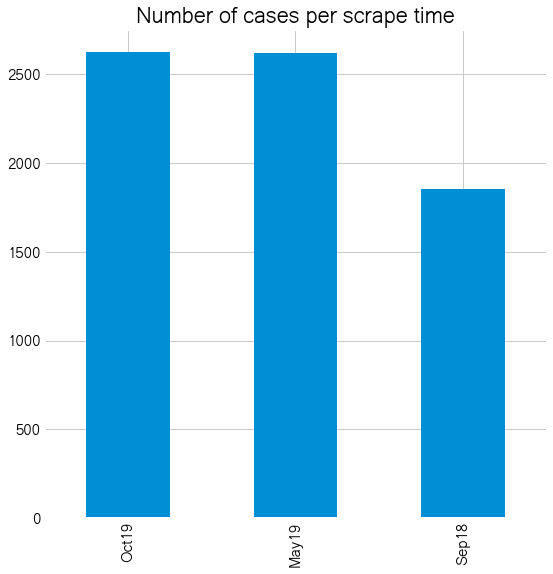

In [7]:
berlin.date.value_counts().plot.bar()
plt.title("Number of cases per scrape time")
plt.show()

In [8]:
berlin.corr()

,serviceCharge,telekomHybridUploadSpeed,newlyConst,balcony,electricityBasePrice,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,...,numberOfFloors,noRoomsRange,garden,livingSpaceRange,heatingCosts,lastRefurbish,livingSpace_m,totalRent_m,logRent,logSpace
serviceCharge,1.000000,NaN,0.068294,0.169764,-8.023866e-03,0.180880,-0.032964,-0.048949,0.637221,0.183751,...,2.448584e-02,0.499480,0.099476,0.617345,4.809631e-01,-2.064810e-02,0.625886,0.637221,0.612898,0.615842
telekomHybridUploadSpeed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
newlyConst,0.068294,NaN,1.000000,0.167290,-5.530394e-02,0.080291,0.039857,0.076350,0.209439,0.528885,...,8.244309e-02,0.082435,0.094604,0.063749,8.317371e-03,1.422385e-01,0.055550,0.209439,0.215594,0.068379
balcony,0.169764,NaN,0.167290,1.000000,-1.395029e-02,0.092909,-0.074795,0.004735,0.176456,0.290107,...,3.922812e-02,0.188202,0.098815,0.195327,1.086853e-01,4.044212e-02,0.193653,0.176456,0.184641,0.213870
electricityBasePrice,-0.008024,NaN,-0.055304,-0.013950,1.000000e+00,0.019915,0.017950,-0.021584,0.003923,-0.030259,...,-4.695372e-16,-0.011940,0.009251,0.005777,-8.337427e-16,1.071955e-14,0.000585,0.003923,-0.001024,-0.003713
picturecount,0.180880,NaN,0.080291,0.092909,1.991516e-02,1.000000,0.060001,0.001806,0.377344,-0.038880,...,-1.231319e-02,0.231857,0.136733,0.309554,2.494427e-01,7.752035e-02,0.315655,0.377344,0.391798,0.303932
pricetrend,-0.032964,NaN,0.039857,-0.074795,1.794951e-02,0.060001,1.000000,-0.081751,0.086727,-0.145257,...,1.453482e-01,-0.048295,-0.078556,-0.030397,6.745129e-03,3.289204e-02,-0.031976,0.086727,0.102276,-0.031820
telekomUploadSpeed,-0.048949,NaN,0.076350,0.004735,-2.158413e-02,0.001806,-0.081751,1.000000,-0.066758,0.055584,...,-1.704165e-02,-0.002485,-0.032169,-0.049645,-5.674581e-02,8.041680e-02,-0.048352,-0.066758,-0.065293,-0.043089
totalRent,0.637221,NaN,0.209439,0.176456,3.923128e-03,0.377344,0.086727,-0.066758,1.000000,0.079445,...,3.443936e-02,0.624750,0.120596,0.782584,5.088027e-01,5.440610e-02,0.798040,1.000000,0.969151,0.769150
yearConstructed,0.183751,NaN,0.528885,0.290107,-3.025939e-02,-0.038880,-0.145257,0.055584,0.079445,1.000000,...,1.972486e-01,0.067339,0.098415,0.008290,5.812644e-05,1.137695e-01,0.000356,0.079445,0.069064,0.021456


In [9]:
berlin["livingSpace"].mean()

76.56925690919347

In [10]:
berlin["totalRent"].mean()

1217.385448392555

In [11]:
berlin["totalRent"].median()

1083.13

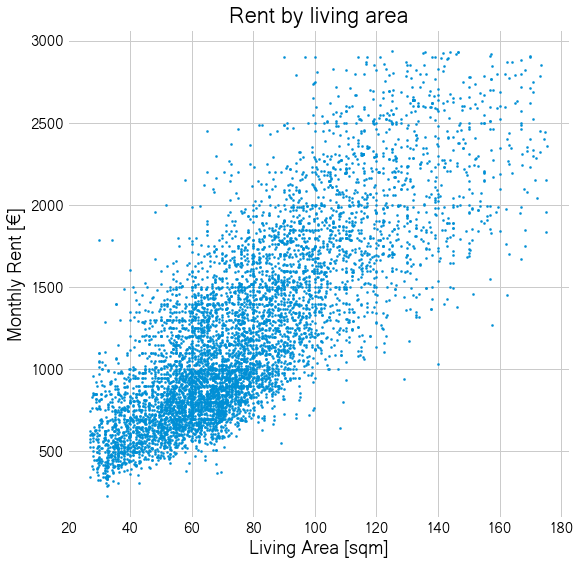

In [12]:
plt.figure(figsize=(9,9))
plt.scatter(berlin.livingSpace, berlin.totalRent, s=4)
plt.title("Rent by living area")
plt.xlabel("Living Area [sqm]")
plt.ylabel("Monthly Rent [€]")
plt.show()

Before working with the data, we will rescale and normalize the living area and also rescale the total rent:

In [13]:
berlin["livingSpace_s"] = (berlin["livingSpace"] - berlin["livingSpace"].mean()) / np.std(berlin["livingSpace"])
berlin["totalRent_s"] = berlin["totalRent"] / 100

# saving for later
berlin.to_csv("../data/berlin.csv", encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC) # special quoting necessary because otherwise description messes up

/home/corrie/.local/share/virtualenvs/PyLadies-Bayesian-Tutorial-HLPPdyhP/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/corrie/.local/share/virtualenvs/PyLadies-Bayesian-Tutorial-HLPPdyhP/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We will have to standardize/destandardize area a few times, so we will use small helper functions for this:

In [ ]:
def standardize_area(x):
    return ( x - berlin["livingSpace"].mean()) / np.std(berlin["livingSpace"])
    
def destandardize_area(x):
    return ( x * np.std(berlin["livingSpace"]) ) + berlin["livingSpace"].mean()    

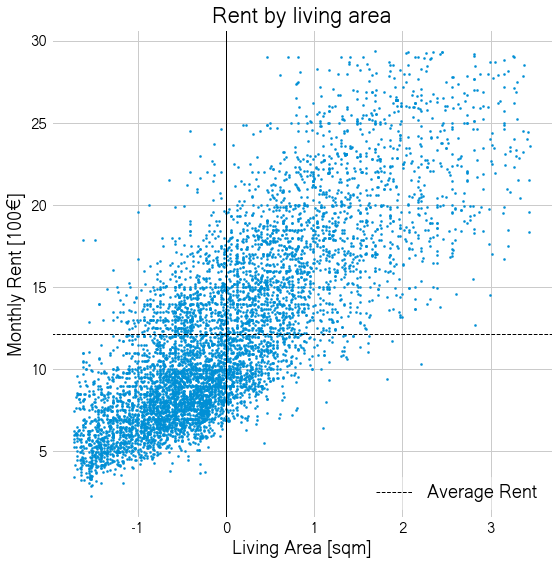

In [28]:
plt.figure(figsize=(9,9))
plt.scatter(berlin.livingSpace_s, berlin.totalRent_s, s=4)
plt.title("Rent by living area")
plt.xlabel("Living Area [sqm]")
plt.ylabel("Monthly Rent [100€]")
plt.axvline(x=0, c="k", linewidth=1)
plt.axhline(y=np.mean(berlin.totalRent_s), c="k", linewidth=1, linestyle="--", label="Average Rent")
plt.legend()
plt.show()

Looking at the plot, it roughly looks like a linear relationship between area and monthly rent. Indeed, the bigger the flat, the more expensive it should be. So we will start our modelling with a linear model.

So in math notation, our model can be written as follows:

$$ \text{rent} \approx \alpha + \beta \text{area} $$

This is the same as
$$ \text{rent} = \alpha + \beta \text{area} + \epsilon$$
where $\epsilon$ is normally distributed, i.e. $\epsilon \sim \text{Normal}(0, \sigma)$. This can be rewritten as
$$ \text{rent} \sim \text{Normal}(\alpha + \beta \text{area}, \sigma).$$

For easier reading, we rewrite this again:
$$\begin{align*} \text{rent} &\sim \text{Normal}(\mu, \sigma) \\
\mu &= \alpha + \beta \text{area}
\end{align*}$$
This will be our first model!

## Adding a Bayesian ingredient: Priors

Before implementing this model, let's shortly think about what the parameters $\alpha$ and $\beta$ mean here.

We will use the model with our rescaled data and thus $\alpha$ the intercept is the rental price of an average sized flat. (For averaged sized flats, the scaled area is 0).

$\beta$ is then the increase in rent if the flat is one standard deviation larger. One standard deviation is 29sqm which is roughly the average size for a room (check living space divided by number of rooms _noRooms_). Thus $\beta$ is roughly the increase in rent if the flat would have one more room. 

$\sigma$ is how much the rent can differ for two flats of the same size. Concretely, it is how much the rent can differ from the average rent for flats of the same size. As our model says that the rent is normally distributed, about 95% of the cases should be within $2\sigma$ of the average rent.
As error term, $\sigma$ is always positive.

Thinking about what the parameters mean beforehand is very important in a Bayesian analysis since we need to specify priors. Priors are what we think the parameters could be before seeing the data. And, obviously, to be able to say what range the parameters would be in, it would be good to know what the parameters mean.


If we don't know anything about the problems, we might want to specify priors that are very uninformative and vague. 
We could for example specify $\alpha$ and $\beta$ as being somewhere between -10,000 and + 10,000:

In [15]:
import pymc3 as pm

In [16]:
with pm.Model() as mod:
    alpha = pm.Normal('alpha', mu=0, sigma=10000)
    beta = pm.Normal('beta', mu=0, sigma=10000)

A PyMC-Model is specified in a context. Before we can actually specify the model, we need to specify the priors, since, as usual in Python, each variable we want to use need to declared beforehand.
In PyMC, you always need to specify the name of the variable twice. This is so that the variable knows its own name.

If you print the model, it renders nicely in a more mathy looking description:

In [17]:
mod

We can add to the model by opening the context again.
To for example add a prior for sigma, we can proceed as follows:

In [18]:
with mod:
    sigma = pm.HalfNormal('sigma', sigma=10000)

Since $\sigma$ as error term is always a positive variable, we need to use a distribution that is always positive as w or the Hell. One commonly used distribution for this is the Half-Normal. A normal distribution that is cut in half and only positive.
Other commonly used distributions for $\sigma$ are for example the Exponential or the Half-Cauchy.

Now that we specified some priors, we can write out the complete model:

In [19]:
with mod:
    mu = alpha + beta*berlin["livingSpace_s"]
    
    rent = pm.Normal('rent',mu=mu, sigma=sigma,
                    observed=berlin["totalRent_s"])

The PyMC-Model is written very similar to how the model was specified above. 

Note that for the outcome variable, we need to specify the observed data.
Usually the whole model is written as one:

In [20]:
with pm.Model() as mod:
    alpha = pm.Normal("alpha", mu=0, sigma=10000)
    beta = pm.Normal("beta", mu=0, sigma=10000)
    sigma = pm.HalfNormal("sigma", sigma=10000)
    
    mu = alpha + beta*berlin["livingSpace_s"] 
    rent = pm.Normal("rent", mu=mu, sigma=sigma,
                    observed=berlin["totalRent_s"])

Especially in the beginning, when starting out with Bayesian modelling, picking priors can seem a bit daring. 
Does it make a difference if we use $\text{Normal}(0,100)$ or $\text{Normal}(0, 1000)$?
What's with using different distributions?


There are a few tips that help a bit with picking a good prior. The first one is to visualize your priors. We can do this with PyMC by sampling from our priors.
This is the similar to sampling from the specified distributions using numpy or scipy. However, on top of sampling from the probability distributions, it then also computes $\mu$ (the linear part of the model) using the samples and the predictor variables. It then uses the computed $\mu$ and the samples from $\sigma$ to sample possible outcome values. Even though we specified the target variable (in Machine Learning this one is usually called `y`) it does not use this (yet) and is thus very quick.

In [21]:
with mod:
    priors = pm.sample_prior_predictive(samples=1000)

We will use [ArviZ](https://arviz-devs.github.io/arviz/) to keep track of the different artifacts computed from our model and to visualize them.

In [22]:
import arviz as az
pm_data = az.from_pymc3(prior = priors)

ArviZ comes with many plots that are useful to analyze Bayesian models.
Let's start looking at the priors for our three model parameters:

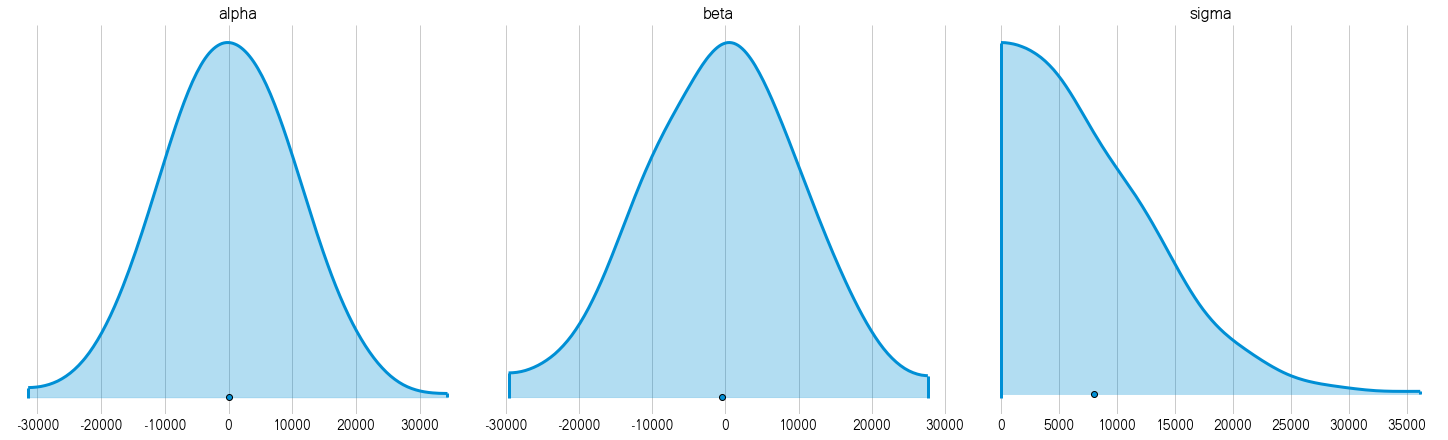

In [23]:
az.plot_density(pm_data, 
                # we want to plot the prior
                group="prior", 
                # and only the following variables
                var_names=["alpha", "beta", "sigma"],
                # just some settings to make it prettier
               shade=0.3, bw=8, figsize=(20,6), credible_interval=1)
plt.show()

This doesn't look super interesting, it is basically just a density plot of the distributions we gave for the priors.
More interesting is to visualize what rental prices these prior distributions would produce given the predictor data.
Unfortunately, there is no ArviZ plot for this yet, but we can do this ourselves without too much work.

The object `priors` contains a numpy array for `rent`. Check what it contains:

In [24]:
priors["rent"].shape

(1000, 7092)

For each observation in our dataframe (7092 obs) it computed 1000 samples for possible rent prices, using the samples from `alpha`, `beta`, and `sigma` together with the corresponding living area from this observation.

We can flatten the matrix to obtain one big array and plot a histogram:

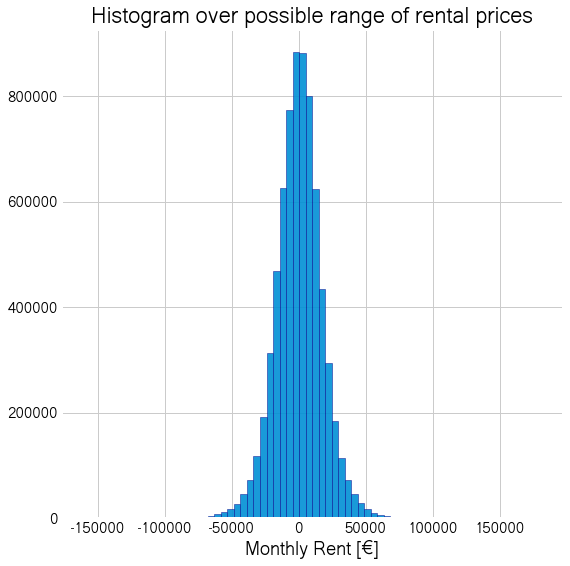

In [25]:
plt.hist(priors["rent"].flatten()*100, alpha=0.9, ec="darkblue", bins=70)
plt.title("Histogram over possible range of rental prices")
plt.xlabel("Monthly Rent [€]")
plt.show()

Compare this with the histogram over the actual rental prices:

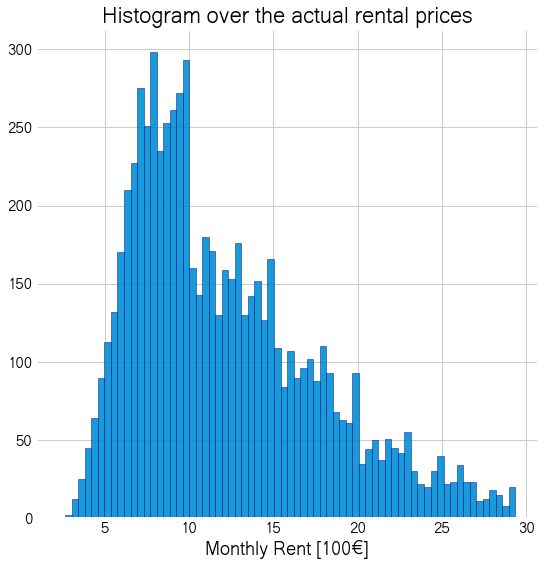

In [26]:
plt.hist(berlin["totalRent_s"]*100, alpha=0.9, ec="darkblue", bins=70)
plt.title("Histogram over the actual rental prices")
plt.xlabel("Monthly Rent [€]")
plt.show()

The histograms don't look very similar and the range of the sampled rents is completly off! A rent of 50,000€ per month doesn't sound very realistic.


Another good way to understand the prior better is to visualize the model that it would produce. In our case, the model is a line determined by the intercept $\alpha$ and the slope $\beta$. 
We can thus sample 50 $\alpha$ and $\beta$s and multiply this with the range of area values:

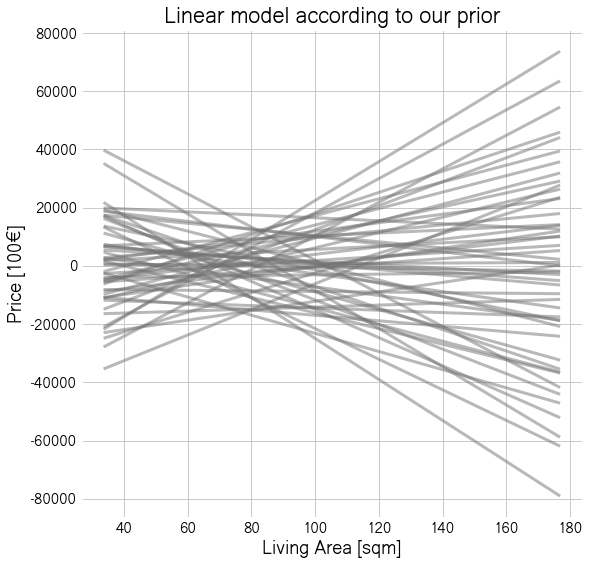

In [29]:
area_s = np.linspace(start=-2, stop=3.5, num=50)
draws = np.random.choice(len(priors["alpha"]), replace=False, size=50)
alpha = priors["alpha"][draws]
beta = priors["beta"][draws]

mu = alpha + beta * area_s[:, None]


plt.plot(destandardize_area(area_s), mu*100, c="#737373", alpha=0.5)
plt.xlabel("Living Area [sqm]")
plt.ylabel("Price [€]")
plt.title("Linear model according to our prior")
plt.show()

Exercise: Use `plt.axhline(y=my_rent)` to compare the sampled lines with your own rent, the most expensive, reasonable rent you can think off and the cheapest possible rent you can think off. I also like to google what is the known most expensive rent one can find in Berlin (or elsewhere) and see how it compares to the model.

You could also add these benchmarks to the histogram using `plt.axvline(x=my_rent)`.

These priors are obviously not very realistic! Luckily, we all know a bit about rents, so even without looking at the data, we can think of better priors.

Write a new model `mod_informed` that uses the same linear part as above, but better priors. You can use the same distributions as above and only change its parameters. I recommend you to try various priors and check what effects they have on the resulting model and its outputs.

Remember: 
- $\alpha$ the intercept is the rental price of an average sized flat (averaged sized flat is 77sqm).
- $\beta$ the slope is roughly the increase in rent if the flat would have one more room
- $\sigma$ is how much the rent can differ for two flats of the same size. As error term, $\sigma$ is always positive.

Always keep in mind the scale of your data!

In [ ]:
with pm.Model() as mod_informed:
    # new model goes here
    
    mu = ...
    
    rent = ...
    
    priors = ...

I made functions for the above plot, so you don't have to copy the whole plot code: `compare_hist(priors, berlin)` to plot the two histograms and `draw_models(priors, berlin)` to plot sampled lines from our model:

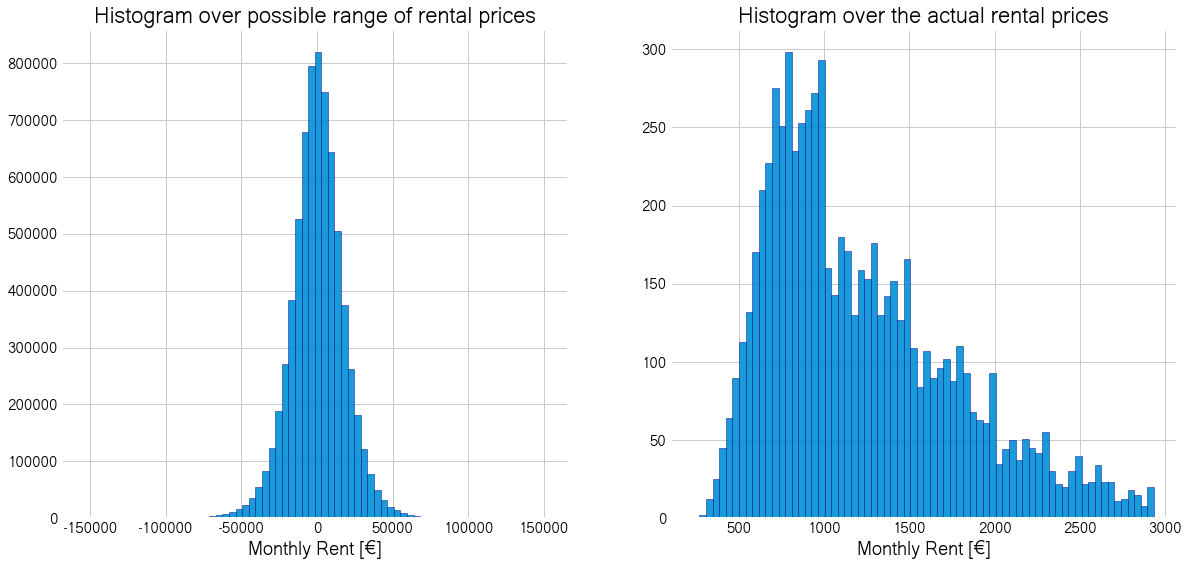

In [28]:
from utils import compare_hist, draw_models

compare_hist(priors, berlin)
plt.show()

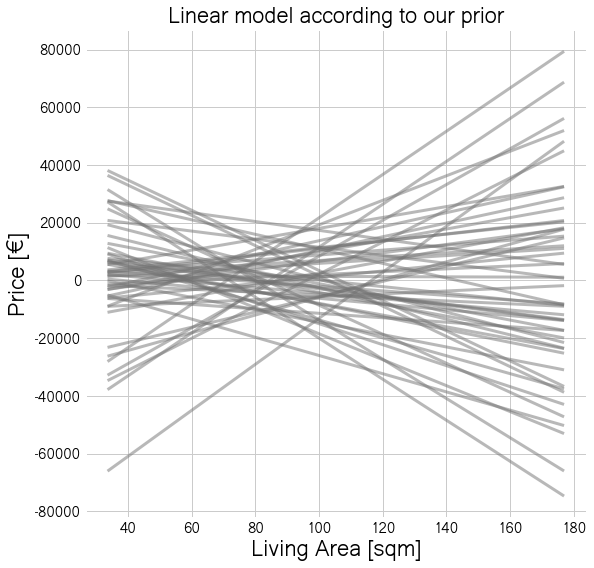

In [29]:
draw_models(priors, berlin)
plt.show()

Questions to explore regarding different priors:
- We've seen above what happens when we use overly vague priors, what happens if we use very narrow priors? What problems could arise?
- So far, we've only used the normal distribution for the priors. Try out some different distributions, e.g.
    - Uniform distribution, e.g. over -1000 to + 1000
    - Student-T distribution
- Since we know that rents should increase for larger flats, we know that the slope $\beta$ should be positive, how could we bias our priors to positive values?

Optional exercises for at home: 
To understand better how something works, it often helps to implement it oneself. Try implementing yourself sampling from the prior using only numpy or scipy.